# Imports

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests

# Task 1

## Reading data

In [28]:
df = pd.read_csv('Mehra.csv', index_col=0, parse_dates=True)
df

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1959-01-01,1606.4,1608.3,47.5,36.9,37.4,26.9,32.3,23.1
1959-04-01,1637.0,1622.2,47.5,37.4,37.5,27.0,32.2,23.4
1959-07-01,1629.5,1636.2,48.7,37.6,37.6,27.1,32.4,23.4
1959-10-01,1643.4,1650.3,48.8,37.7,37.8,27.1,32.5,23.8
1960-01-01,1671.6,1664.6,49.1,37.8,37.8,27.2,32.4,23.8
...,...,...,...,...,...,...,...,...
1988-07-01,4042.7,3971.9,179.6,131.5,124.9,106.2,123.5,92.8
1988-10-01,4069.4,3995.8,181.3,133.3,126.2,107.3,124.9,92.9
1989-01-01,4106.8,4019.9,184.1,134.8,127.7,109.5,126.6,94.0


In [29]:
df.columns

Index(['rgnp', 'pgnp', 'ulc', 'gdfco', 'gdf', 'gdfim', 'gdfcf', 'gdfce'], dtype='object')

## Differencing data in a loop and checking when all of time series becoming stationary

In [30]:
areAllStationary = False
rows = {}
diffDF = df.copy()
i = 1
while areAllStationary == False:
    diffDF = diffDF.diff()
    stationCheck = []
    for col in df.columns:
        stationCheck = stationCheck + [adfuller(diffDF[col].dropna())[1]<0.05]
    print(i, stationCheck)
    rows[i] = stationCheck
    areAllStationary = all(stationCheck)
    i = i+1

1 [True, False, True, False, False, True, False, False]
2 [True, True, True, True, True, True, True, True]


In [31]:
results = pd.DataFrame.from_dict(rows, orient = 'index', columns = df.columns)
results

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
1,True,False,True,False,False,True,False,False
2,True,True,True,True,True,True,True,True


### We can see that for the second order of differencing all time series are stationary.

# Task 2

In [33]:
diffDF = diffDF.dropna()
diffDF

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1959-07-01,-38.1,0.1,1.2,-3.000000e-01,0.0,0.0,0.3,-0.3
1959-10-01,21.4,0.1,-1.1,-1.000000e-01,0.1,-0.1,-0.1,0.4
1960-01-01,14.3,0.2,0.2,-7.105427e-15,-0.2,0.1,-0.2,-0.4
1960-04-01,-33.0,0.1,0.2,1.000000e-01,0.2,0.1,0.5,0.1
1960-07-01,6.4,0.1,-0.1,-1.000000e-01,-0.1,-0.2,-0.3,0.1
...,...,...,...,...,...,...,...,...
1988-07-01,-3.9,0.2,-2.1,-4.000000e-01,0.2,-1.5,0.9,-0.3
1988-10-01,-5.3,0.1,0.8,6.000000e-01,-0.3,1.0,-1.1,-0.4
1989-01-01,10.7,0.2,1.1,-3.000000e-01,0.2,1.1,0.3,1.0


## Calculating Granger Matrix

In [46]:
casualityDict = {}
for col1 in diffDF:
    casualityDict[col1] = {}
    for col2 in diffDF:
        res = grangercausalitytests(diffDF[[col1,col2]], maxlag=12, verbose=False)
        casualityDict[col1][col2] = min(list(map(lambda x: x[0]['ssr_chi2test'][1], res.values())))
grangerDF = pd.DataFrame(casualityDict).T
grangerDF

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
rgnp,9.999999e-01,0.004453,2.875256e-06,0.028141,2.078760e-01,0.095896,2.542349e-02,0.004623
pgnp,2.140627e-02,1.000000,6.286447e-04,0.057647,1.695280e-07,0.000937,1.990574e-07,0.108918
ulc,1.720399e-07,0.453271,1.000000e+00,0.000266,7.664548e-02,0.014229,1.148651e-01,0.000962
gdfco,6.273846e-02,0.194061,5.500748e-01,1.000000,1.270424e-02,0.077287,8.099623e-01,0.082542
gdf,2.357566e-04,0.017838,7.317498e-07,0.003504,1.000000e+00,0.000143,4.977663e-02,0.002364
gdfim,1.898505e-02,0.046037,1.722849e-02,0.000029,8.628849e-04,1.000000,1.200579e-02,0.000466
gdfcf,7.127062e-05,0.046132,8.270006e-04,0.101157,5.688046e-02,0.000292,1.000000e+00,0.000018
gdfce,2.048481e-02,0.079810,1.267708e-03,0.001004,1.923032e-06,0.010624,3.076236e-03,1.000000


### The results look so good, so let's plot heatmap based on them.

<AxesSubplot:>

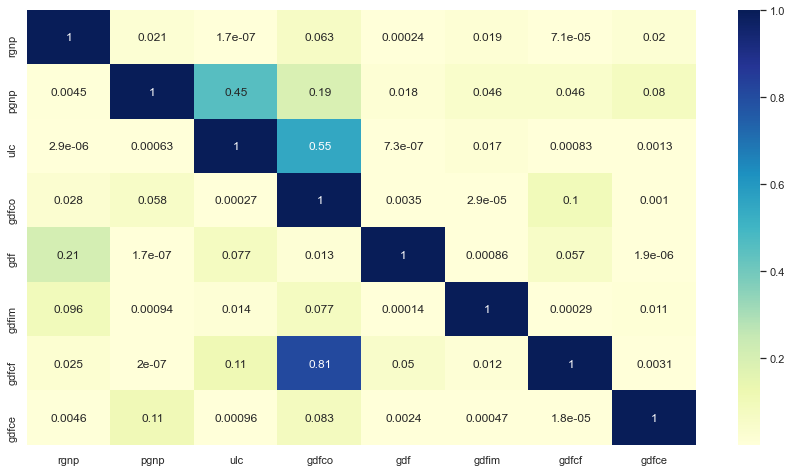

In [51]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(grangerDF, annot=True, cmap="YlGnBu")